# Тестовое задание в команду продуктовой аналитики, Gett.

В папке с заданием два датасета - data_orders - содержит выборку данных по заказам пользователей и включает такие колонки как:
* order_datetime -  время заказа
* origin_longitude - долгота
* origin_latitude - широта
* m_order_eta - время до прибытия машины
* order_gk - номер заказа
* order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* is_driver_assigned_key - был ли назначен водитель
* cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен водителю по данному заказу.


В момент когда клиент нажимать на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых водителей и предлагаем им заказ. В задании предлагается исследовать некоторые метрики матчинга для заказов, которые не завершились успешно (клиент в итоге не получил машину). 

# **0.** Preparing data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

offers = pd.read_csv('https://github.com/slgero/testovoe/raw/master/Gett/data/data_offers.csv')

orders = pd.read_csv('https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_orders.csv')

In [2]:
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [3]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [4]:
orders.isna().mean()

order_datetime                   0.000000
origin_longitude                 0.000000
origin_latitude                  0.000000
m_order_eta                      0.737402
order_gk                         0.000000
order_status_key                 0.000000
is_driver_assigned_key           0.000000
cancellations_time_in_seconds    0.318122
dtype: float64

In [5]:
orders['order_gk'].duplicated().mean()

0.0

# **1.** Build the distribution of orders for reasons of failure: cancellations before and after the appointment of a driver, rejects

In [6]:
orders.order_status_key.value_counts(normalize = True)

4    0.681878
9    0.318122
Name: order_status_key, dtype: float64

68% of our rejectings were canceled by client, the rest - 31% were rejected by the system itslef. 

In [7]:
orders.groupby(['is_driver_assigned_key','order_status_key'])['order_gk'].count().reset_index()

,is_driver_assigned_key,order_status_key,order_gk
0,0,4,4496
1,0,9,3406
2,1,4,2811
3,1,9,3


In [8]:
orders[orders['is_driver_assigned_key']==0]['order_status_key'].value_counts(normalize=True)

4    0.56897
9    0.43103
Name: order_status_key, dtype: float64

In [9]:
orders[orders['is_driver_assigned_key']==1]['order_status_key'].value_counts(normalize=True)

4    0.998934
9    0.001066
Name: order_status_key, dtype: float64

If the driver is appointed - cancellation is happening only because of the client - in 99%. In the case where driver wasn't appointed yet - cancellation and rejection are happening in equal share outnumbered by the client.

In [10]:
orders['fail'] = (orders['order_status_key'] == 9)*1

In [11]:
orders.groupby('is_driver_assigned_key')['fail'].agg(['count','mean'])

,count,mean
is_driver_assigned_key,,
0,7902,0.431030
1,2814,0.001066


In [12]:
orders['fail'].mean()

0.3181224337439343

Rejecting by the sistem is happening in 32% out of all cases

# **2.** Build a graph of the distribution of failures by hours - is there a tendency that at some hours the share of this or that category is abnormally high?

In [13]:
orders['hour'] = orders['order_datetime'].str[:2]

In [14]:
orders.groupby('hour')['fail'].agg(['count', 'mean'])

,count,mean
hour,,
00,683,0.387994
01,471,0.348195
02,555,0.432432
03,513,0.438596
04,152,0.401316
05,67,0.402985
06,159,0.283019
07,447,0.284116
08,1082,0.328096


In [15]:
t = orders.groupby('hour')['fail'].agg(['count','mean'])

<AxesSubplot:xlabel='hour'>

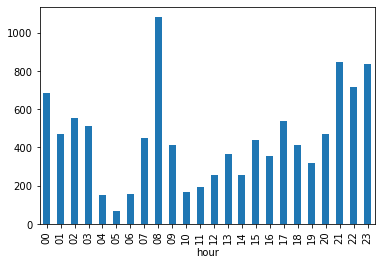

In [16]:
t['count'].plot(kind = 'bar')

The most cancelling are happening at 8 am - probably because it is the time when most people start working and we do not have enought drivers. Also, a lot of cancellation is happening closer to the night time - from 21 to 23 in the nigh. 4, 5 and 6 am are dead hours.

<AxesSubplot:xlabel='hour'>

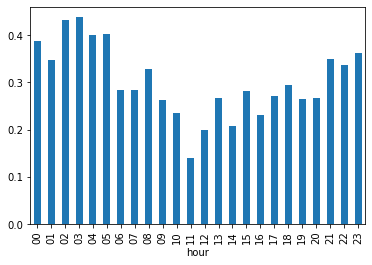

In [17]:
t['mean'].plot(kind = 'bar')

Almost half of canceling happening because of rejection from 2 to 5 am - probably luck of drivers. Amount of rejection increases from 21 to 23 at night too.

# **3**. Plot the graphs of the average time to cancellation (cancellations_time_in_seconds) with and without a driver, by the hour. Can conclusions be drawn from this graph

In [18]:
t = orders.groupby('hour')['is_driver_assigned_key'].agg(['count', 'mean'])

<AxesSubplot:xlabel='hour'>

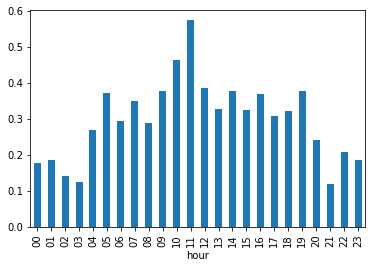

In [19]:
t['mean'].plot(kind='bar')

In [20]:
orders[orders['is_driver_assigned_key']==0].groupby('hour')['cancellations_time_in_seconds'].agg(['mean','median'])

,mean,median
hour,,
00,111.557047,89.0
01,98.132420,84.0
02,106.438819,87.0
03,104.361607,83.5
04,90.000000,65.5
05,121.800000,112.0
06,124.955224,85.0
07,112.628049,95.5
08,120.702179,95.0


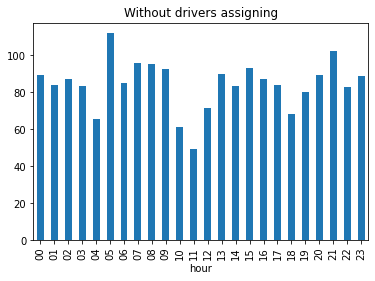

In [21]:
orders[orders['is_driver_assigned_key']==0].groupby('hour')['cancellations_time_in_seconds'].median().plot(kind = 'bar')
plt.title("Without drivers assigning");

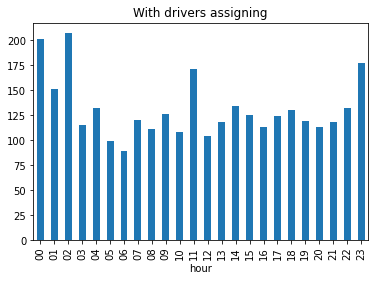

In [22]:
orders[orders['is_driver_assigned_key']==1].groupby('hour')['cancellations_time_in_seconds'].median().plot(kind = 'bar')
plt.title("With drivers assigning");

In [23]:
orders.groupby('is_driver_assigned_key')['cancellations_time_in_seconds'].agg(['count','mean','median'])

,count,mean,median
is_driver_assigned_key,,,
0,4496,110.371441,88.0
1,2811,233.897901,127.0


It takes less time to cancel if driver is not assigned yet. According to the hours is does not matter much

# **4.** Plot the distribution of the average ETA by the hour. How can you explain this kind of graph?

In [24]:
orders.groupby('hour')['m_order_eta'].agg(['count','median'])

,count,median
hour,,
00,122,298.0
01,88,297.5
02,78,298.0
03,64,328.0
04,41,238.0
05,25,358.0
06,47,359.0
07,156,584.5
08,314,658.0


<AxesSubplot:xlabel='hour'>

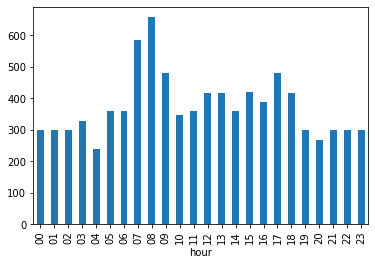

In [25]:
orders.groupby('hour')['m_order_eta'].median().plot(kind = 'bar')

Customer waits till the car would com the most in the morning - from 7 till 10 pm.

# 5. Column drivers_offered - shows how many drivers saw the order and could accept it. Plot an hourly breakdown of the average number of drivers to whom an order was offered. What can you say about it about the excess / shortage of drivers at certain times?

In [47]:
df = offers.groupby('order_gk')['offer_id'].nunique().reset_index()

In [48]:
df

,order_gk,offer_id
0,3000551431542,1
1,3000551431560,2
2,3000551431566,5
3,3000551431577,2
4,3000551431592,7
...,...,...
97962,3000633196069,2
97963,3000633196079,1
97964,3000633196163,7
97965,3000633196174,2


In [49]:
df = df.merge(orders, on = 'order_gk', how = 'right')

In [50]:
df['offer_id'] = df['offer_id'].fillna(0)

<AxesSubplot:>

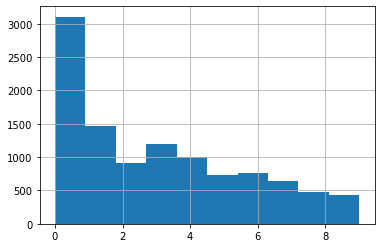

In [51]:
df['offer_id'].hist()

In [52]:
df.groupby('hour')['offer_id'].agg(['count','mean'])

,count,mean
hour,,
00,683,2.918009
01,471,2.770701
02,555,2.657658
03,513,2.764133
04,152,1.493421
05,67,1.656716
06,159,2.465409
07,447,3.503356
08,1082,3.572089


<AxesSubplot:xlabel='hour'>

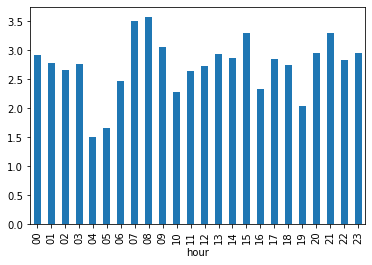

In [44]:
df.groupby('hour')['offer_id'].mean().plot(kind='bar')

In [45]:
df['offer_id'].mean()

2.917879805897723

According to the plot we see that most of the time 2-3 drivers see the same offer. Luck of drivers see the order from 4 til 6 am - in fairness it is a dead hour so we dont have much drivers working so it makes sense.